# Analysis of the Feedbacks (which are tagged)

In [484]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import random
import re
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [4]:
raw_df = pd.read_csv('NLP_TakeHome_Feedbacks.csv', encoding = 'ISO-8859-1')

raw_df.head()

,id,req_user_agent,country,is_app_or_web,device_type,ds,tags,feedback
0,207160,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,US,Mozilla,other,2/25/17,Notifications | Mobile app,It is a nightmare trying to get in touch with ...
1,207163,Airbnb/17.07 iPhone/10.2 Type/Phone,US,Airbnb,iphone,2/25/17,Booking | Weekly pricing,It won't let me book a upcoming stay and I hav...
2,207168,Airbnb/17.07 iPhone/10.2.1 Type/Phone,US,Airbnb,iphone,2/25/17,Review,Everything is awesome. However using the app i...
3,207169,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,US,Mozilla,other,2/25/17,Booking,{{NAME}} experience with special offers. I was...
4,207182,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:51.0) ...,US,Mozilla,other,2/25/17,Calendar availability,"Calendar {{NAME}} is not working, please advis..."


In [7]:
#For now drop (req_user_agent, country, is_app_or_web, device_type, ds) columns
#Keep the id column as we may need to bring in other information. This id will help later

df = raw_df.drop(["req_user_agent", "country", "is_app_or_web", "device_type", "ds"],axis=1)

print(raw_df.shape)
print(df.shape)

(8949, 8)
(8949, 3)


In [9]:
df.head()

,id,tags,feedback
0,207160,Notifications | Mobile app,It is a nightmare trying to get in touch with ...
1,207163,Booking | Weekly pricing,It won't let me book a upcoming stay and I hav...
2,207168,Review,Everything is awesome. However using the app i...
3,207169,Booking,{{NAME}} experience with special offers. I was...
4,207182,Calendar availability,"Calendar {{NAME}} is not working, please advis..."


### Let us do some exploratory analysis


Text(0.5,1,'Counts of the top 10 labels/tags')

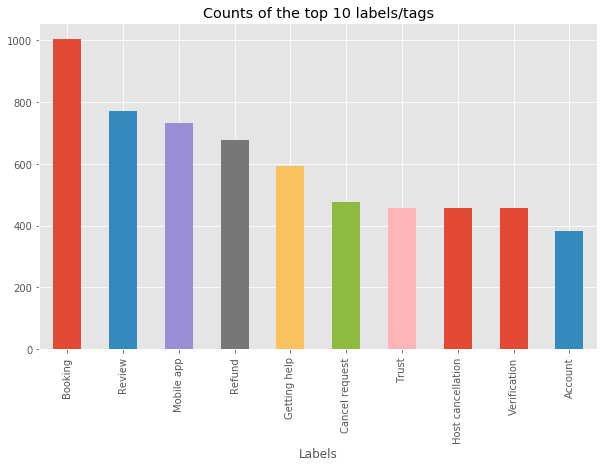

In [70]:
#Let us first get some stat on the labels

ListOfLabels = df['tags'].apply(lambda x: x.split('|')).tolist()

ListOfLabels = [x.strip() for labels in ListOfLabels for x in labels]

labelCount_df = pd.DataFrame(pd.Series(ListOfLabels).value_counts()).reset_index()

labelCount_df.columns = ['Labels', 'Count']

labelCount_df.head(10).plot(x='Labels', y='Count', kind='bar',legend=False, figsize=(10,6))

plt.title("Counts of the top 10 labels/tags")

The number of unique tags is 615

The most common label seems to be Booking, followed by Review, Mobile app, Refund, Getting Help.

However, there are a number of tags which appeared only once in our dataset. Let us count how many.


Text(0.5,1,'% of labels appearing above threshold')

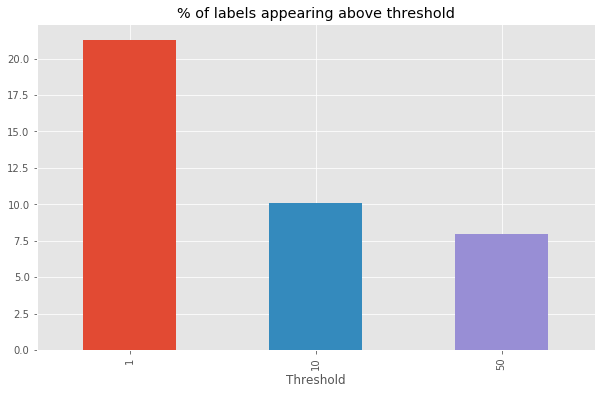

In [80]:
dataCount = []

for i in [1,10,50]:
    a = labelCount_df[labelCount_df['Count'] < i+1].shape[0]
    b = labelCount_df.shape[0]
    dataCount.append((i, ((b-a)/b)*100))
    

dataCount_df = pd.DataFrame(dataCount,columns=['Threshold','%aboveThreshold'])

dataCount_df.plot(x='Threshold',y='%aboveThreshold',kind='bar',legend=False,figsize=(10,6))
plt.title("% of labels appearing above threshold")

484 out of 615 appears only once in the label. So roughly **21% of the labels** appear more than **once**. This number goes down even further. Only **10%** of the labels shows up **10** or more time. The percentage is about **7.5%** for labels appearing **50** or more time. This shows most of the labels are hardly used to tag the feedbacks. 

### Multi-label per feedback

In [123]:
tag_stat_df = pd.DataFrame(df['tags'].apply(lambda x: x.split('|')))['tags']

print('Max number of tags for a feedback is {}'.format(tag_stat_df.apply(lambda x: len(x)).max()))

print('Min number of tags for a feedback is {}'.format(tag_stat_df.apply(lambda x: len(x)).min()))

print('Average number of tags per feedback is {}'.format(tag_stat_df.apply(lambda x: len(x)).mean()))

print('Number of feedbacks with 2 or more tags is {}'.format(tag_stat_df.apply(lambda x: 1 if len(x) > 2 else 0).sum()))

Max number of tags for a feedback is 14
Min number of tags for a feedback is 1
Average number of tags per feedback is 1.4790479383171304
Number of feedbacks with 2 or more tags is 1070


In [127]:
print(tag_stat_df[tag_stat_df.apply(lambda x: len(x) > 4)].apply(lambda x: len(x)).mean())

print(tag_stat_df[tag_stat_df.apply(lambda x: len(x) > 4)].apply(lambda x: len(x)).count()/8949)

6.145348837209302
0.019220024583752375


It seems vast majority of feedbacks have only 1 or 2 tags associated with them. Only 1.9% of the feedbacks have 5 or more tags (about 172). 

In order to understand the data a bit more, let us examine the feedbacks with 5 or more tags associated with them.

### Feedbacks with 5 or more tags

In [130]:
fiveOrMoreTags = df[tag_stat_df.apply(lambda x: len(x) > 4)]

In [139]:
fiveOrMoreTags.head().iloc[1,2]

"You won't let me change my email address "

In [140]:
fiveOrMoreTags.to_csv('FiveOrMoreTags.csv', index=False)

#### Analysis of the feedbacks

In [141]:
df.head()

,id,tags,feedback
0,207160,Notifications | Mobile app,It is a nightmare trying to get in touch with ...
1,207163,Booking | Weekly pricing,It won't let me book a upcoming stay and I hav...
2,207168,Review,Everything is awesome. However using the app i...
3,207169,Booking,{{NAME}} experience with special offers. I was...
4,207182,Calendar availability,"Calendar {{NAME}} is not working, please advis..."


Text(0.5,1,'Histogram of Character lengths with size < 5000')

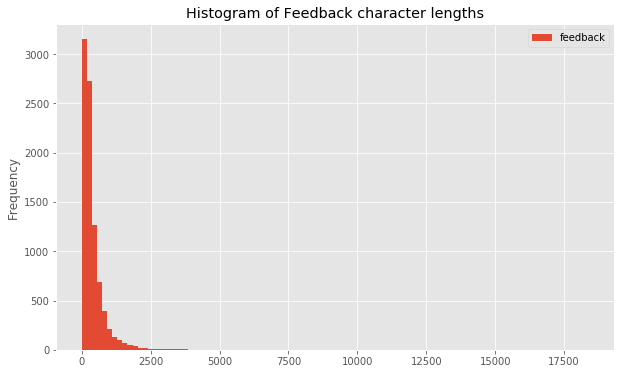

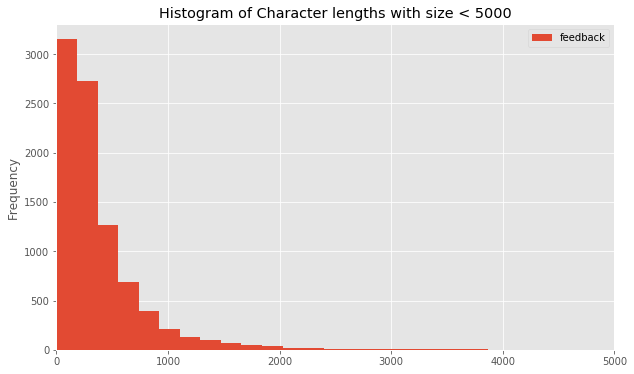

In [195]:
# Distribution of number of characters and words in the feedbacks

charLen = pd.DataFrame(df.feedback.str.len())

charLen.plot.hist(bins=100, figsize=(10,6))
plt.title("Histogram of Feedback character lengths")

charLen.plot.hist(bins=100, figsize=(10,6),xlim=(0, 5000) )
plt.title("Histogram of Character lengths with size < 5000")

Average character length of feedbacks 396.54442829998885
Max char length of the feedbacks 18406.0
Minimum char length of the feedbacks 1.0
80 percentile of the feedbacks is 554.0


Text(0.5,1,'Char lengths atmost 1000')

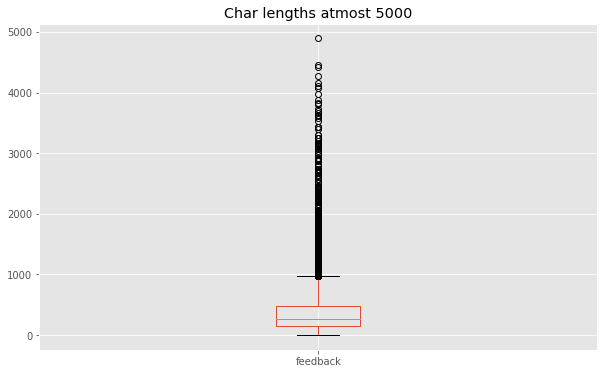

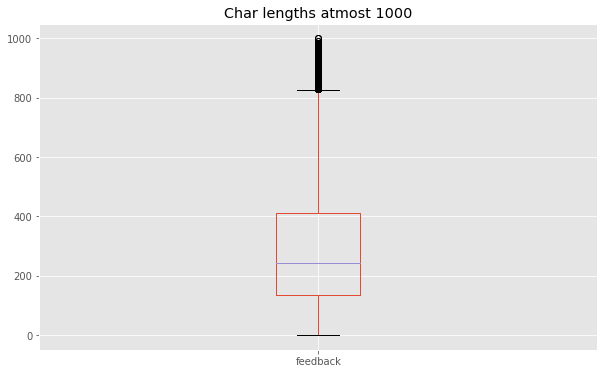

In [194]:
print(f"Average character length of feedbacks {charLen['feedback'].mean()}")

print(f"Max char length of the feedbacks {charLen['feedback'].max()}")

print(f"Minimum char length of the feedbacks {charLen['feedback'].min()}")

print(f"80 percentile of the feedbacks is {charLen['feedback'].quantile(0.8)}")


charLen[charLen['feedback'] < 5000].plot.box(figsize=(10,6))
plt.title("Char lengths atmost 5000")

charLen[charLen['feedback'] < 1000].plot.box(figsize=(10,6))
plt.title("Char lengths atmost 1000")



Above analysis shows that **75%** of the feedbacks are approximately 400 characters long. Longer feedbacks, that is feedbacks with 1000 or more characters consist of only **620** or about **6.9%** of the total number of feedbacks. 

In [254]:
df['feedback'].isnull().sum()

2

There are only two rows in the dataset with empty feedback. We will delete these rows from further consideration.

In [255]:
filtered_df = df[df['feedback'].notnull()]

In [256]:
filtered_df['feedback'].isnull().sum()


0

We see above that there is no empty feedback anymore.

Let us now have a **peek** at the few feedbacks before we proceed further.

In [257]:
print(f"Feedback {0} >> \n {filtered_df['feedback'][0]}\n")

# Generate 5 random integers between 1 and 8947 and look at the feedbacks 
randomInt = random.sample(range(1,8945),k=5)

for i in randomInt:
    print(f"Feedback {i} >> \n {filtered_df['feedback'][i]}\n")


print(f"Feedback {8946} >> \n {filtered_df['feedback'][8946]}\n")

Feedback 0 >> 
 It is a nightmare trying to get in touch with {{NAME}}. Does anyone actually read these questions? I am totally disgusted with you guys at the moment. My issue, (which isn't in any subject listed in help) is this: I received a message/request on my mobile device, (from someone who signed up in 2017)  I tried to respond, but did not get a reply message. I signed into my account on my laptop, but did not see the request!!! Is this a scam?  Is your system down?  We do not want to miss out and affect our response time.   How do we prevent this in the future? Thanks; {{NAME}}

Feedback 2475 >> 
 I can't receive confirm mail from airbnb, I can't book. How can I do?

Feedback 5653 >> 
 I am having a very hard time managing my units with your site's calendar.  I have 30 units listed with you.   Some time ago, calendar was sortable by unit's name, date, price, vacant units, occupied units, etc.  which was extremely helpful.  Please pass this to you IT experts.  Right now the cal

By inspecting the above comments and few others from the csv file itself, we do some text preprocessing to make the feedbacks more amenable to our analysis. 

### Preprocessing

The function below achieves most of it. Note that I intend to replace any digits with empty string except when that indicates money for example $50 as opposed to only 50. Since many of the customer reviews involve "booking" or "refund", I want to replace these amount by the word "dollar".

In [301]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\$\d*","dollar",text)
    text = re.sub(r"\d+","number",text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"wouldn't", "would not",text)
    text = re.sub(r"couldn't", "could not",text)
    text = re.sub(r"mins", "minutes",text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'cus", " because ", text)
    text = re.sub(r"Thx"," Thanks ", text)
    text = re.sub(r"wh{2,}y","why",text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text


In [302]:
filtered_df['feedback'] = filtered_df['feedback'].apply(lambda x: clean_text(x))

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [303]:
#same feedbacks from above
for i in randomInt:
    print(f"Feedback {i} >> \n {filtered_df['feedback'][i]}\n")


Feedback 2475 >> 
 i can not receive confirm mail from airbnb i can not book how can i do

Feedback 5653 >> 
 i am having a very hard time managing my units with your site calendar i have number units listed with you some time ago calendar was sortable by unit name date price vacant units occupied units etc which was extremely helpful please pass this to you it experts right now the calendar is only useful for a single unit host

Feedback 8531 >> 
 hi i am the owner of a house in ibiza and someone i do not know is advertising it without my authorization can you please remove the add from the plateform and act accordingly towards him the person name is guido and is registered under my rental homes in name and the house is added under villa bright thanks for your help frank

Feedback 5826 >> 
 the host accepted my reservation and then cancelled i would like to write a review for them i would also like my money back sooner

Feedback 3123 >> 
 i am having a horrible time trying to contact 

Now looks much better. 

Before we proceed further, we need to modify the tags column in the filtered_df dataframe to make it acceptable for downstream analysis and model building. 

Below we create another column, "modified_tags", each row will be a list of tags instead of a string with tags seperated by "|".

In [590]:
filtered_df['modified_tags'] = filtered_df['tags'].apply(lambda x: x.split("|"))


//anaconda/envs/TensorFlow/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Below the Y variable is going to be our **target variable**. It is a **binarized** version of the 'modified_tags' column in the data frame.

In [524]:
modifiedTags = [[z.strip() for z in x] for x in filtered_df.modified_tags.tolist()]

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(modifiedTags)

Y.shape

(8947, 615)

Note that **Y** is a matrix (numpy array) each column represents one tag/label. 1 represents that the tag is present for that feedback, while 0 means it is not. 

At this point, we would like to see what is the distribution of the tags in the dataset. In other words, what percentage of the feedbacks is represented by each tag. 

In [528]:
percentageOfFeedBack_df = {}
percentageOfFeedBack_df['tags'] = list(mlb.classes_)
percentageOfFeedBack_df['percent_feedback'] = list(Y.mean(axis=0))

percentageOfFeedBack_df = pd.DataFrame(percentageOfFeedBack_df)

percentageOfFeedBack_df = percentageOfFeedBack_df[['tags', 'percent_feedback']]

percentageOfFeedBack_df.head()

In [541]:
print(f"The maximum percentage is {percentageOfFeedBack_df['percent_feedback'].max()}")

print(f"The minimum percentage is {percentageOfFeedBack_df['percent_feedback'].min()}")

print(f"The average percentage is {percentageOfFeedBack_df['percent_feedback'].mean()}")

print(f"90% of the values fall below {percentageOfFeedBack_df['percent_feedback'].quantile(0.9)}")

The maximum percentage is 0.11210461607242651
The minimum percentage is 0.00011176930814798256
The average percentage is 0.0024049483816622223
90% of the values fall below 0.001497708729182989 percentage


#### From the above analysis, we made the following observations:

    * Few of the feedbacks have empty tags. We will get rid off those rows for now. 

    * Only handfull of tags belong to about 10% of the feedbacks. 90% of the tags are associated with only 0.1% of the feedbacks. 

These observations will have **serious consequences during modeling**, as hardly enough feedbacks per tag is available for the learning algorithms to learn them effectively, as a result, more than likely, it will end up predicting only few classes, which will lead to very bad scores. 

Moreover, learning algorithm will effectively learn to predict 0/1 per tag. Since for each tag, number of 0s outnumbers 1s, the learning algorithms will likely learn to predict 0s most of the cases, if not always. More on this later in the explanation after modeling is done. 

Below we will get rid off the rows with empty tags.


In [543]:
print(f"Number of null tags {filtered_df['tags'].isnull().sum()}")

Number of null tags 0


In [587]:
#We see below the reason for the empty tag. We will fix it.
for i,x in enumerate(Y[:,0]):
    if x == 1:
        print(i)

filtered_df.iloc[6022,1]

6022


'Refund |  '

We shall rerun the above code snippets to fix this problem


In [596]:
filtered_df['modified_tags'] = filtered_df['tags'].apply(lambda x: x.split("|"))

modifiedTags = [[z.strip() for z in x] for x in filtered_df.modified_tags.tolist()]
modifiedTags = [[y for y in filter(None,x)] for x in modifiedTags]

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(modifiedTags)

percentageOfFeedBack_df = {}
percentageOfFeedBack_df['tags'] = list(mlb.classes_)
percentageOfFeedBack_df['percent_feedback'] = list(Y.mean(axis=0))

percentageOfFeedBack_df = pd.DataFrame(percentageOfFeedBack_df)

percentageOfFeedBack_df = percentageOfFeedBack_df[['tags', 'percent_feedback']]

percentageOfFeedBack_df.head()

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,tags,percent_feedback
0,50%Charge without refund,0.000112
1,Accidental booking,0.012965
2,Account,0.042808
3,Activate listing,0.021348
4,Addition,0.000112


In [597]:
print(Y.shape)

(8947, 614)


Before go on and build our model, we would like to see what are the top tokens, bigrams, trigrams etc. to aid in our understanding of the dataset as well as building models. To do this, we will consider all the feedbacks together in one document.

We need some of these functions below.

#### Ngram analysis

In [304]:
def process_and_tokenize(text):
    """
    Parameters: 
        text: raw text
    """
    #remove everything except characters
    text = re.sub('^[a-zA-Z]',"", text)

    #remove only digits
    text = re.sub('[0-9]',"",text)

    #tokenize
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    #remove words with length < 3 
    tokens = [x.strip() for x in tokens if len(x) > 1]
    
    lemmatizer = nltk.WordNetLemmatizer()
    # remove stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

def score_ngrams(self, score_fn):
    """Returns a sequence of (ngram, score) pairs ordered from highest to
    lowest score, as determined by the scoring function provided.
    """
    return sorted(self._score_ngrams(score_fn),key=_itemgetter(1), reverse=True)


def NgramScores(tokens, ngram, topK,threshold=5, writeToFile = False):
    """ 
    tokens: tokens obtained after tokenization and other processing
    ngrams could be one of: 'unigram','bigram','trigram'
    topK: integer, produce only top topK ngrams
    threshold: any ngram with lower frequency will be filtered out
    writeToFile: a boolean variable. default is False. If enabled, will generate a .csv file in working folder
    
    Required packages: pandas, nltk
    Note: 1) association measure used: pmi
          2) depends on the score_ngrams function
    
    """
    from nltk.metrics.association import BigramAssocMeasures, TrigramAssocMeasures
    
    if ngram == 'unigram':
        fdist = nltk.FreqDist([x for x in tokens])

        #topK most common unigrams
        mostCommonUnigrams = fdist.most_common(topK)
        df = pd.DataFrame(mostCommonUnigrams)
        df.columns = ['unigram','count']
        if writeToFile:
            df.to_csv('output/top'+str(topK)+str(ngram)+'.csv',index=False)
        return df
    if ngram == 'bigram':
        gram = nltk.collocations.BigramCollocationFinder.from_words(tokens)
        gram_measures = BigramAssocMeasures #nltk.collocations.BigramAssocMeasures()
        

    if ngram == 'trigram':
        gram = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
        gram_measures = TrigramAssocMeasures #nltk.collocations.TrigramAssocMeasures()
          
        
    gram.apply_freq_filter(threshold)
    
    wordTuple = dict()
    for (k,v) in gram.ngram_fd.items():
        wordTuple[k] = v
        
    d = []
    gramScore = gram.score_ngrams(gram_measures.pmi)
    for count,i in enumerate(gramScore):
        if count < topK:
            i = (' '.join(i[0]),i[1], wordTuple[i[0]])
            d.append(i)

    #form the pandas dataframe
    topN= pd.DataFrame(d)
    #we are changing the names of the dataframe columns as appropriate
    topN.columns = [str(ngram),'pmi','count']
    if writeToFile:
        topN.to_csv('output/top'+str(topK)+str(ngram)+'.csv',index=False)
    return topN

def build_top_ngrams(text, topK=20, writeToFile=False):
    """ 
    Usage: This builds a dataframe and write to a file(if enabled) the top K unigrams, bi-, and tri- grams
    
    Parameters: 
        text-- list of text files (10Ks) to extract data from
        topK-- top K ngrams (default is 20)
        writeToFile -- Boolean; to indicate if the results should be written to a file 
    
    """
    
    # preprocess and clean 
    new_tokens = process_and_tokenize(text)
    df = pd.DataFrame()
    for ngram in  ['unigram','bigram','trigram']:
        topGrams = NgramScores(new_tokens, ngram, topK)
        df = pd.concat([df,topGrams], axis=1)
    
    if writeToFile:
        outputFile = 'output/top_'+str(topK)+'_ngrams.csv' 
        df.to_csv(outputFile, index=False)
    
    return df


In [305]:
# Join all the feedbacks into a single string
FdBacks = '. '.join(filtered_df['feedback'].tolist())


In [636]:
#Number of unique tokens
tokens = process_and_tokenize(FdBacks)

print(f"The number of unique tokens present in the corpus of feedbacks is {len(set(tokens))}")

The number of unique tokens present in the corpus of feedbacks is 13353


In [308]:
build_top_ngrams(FdBacks,50)

,unigram,count,bigram,pmi,count,trigram,pmi,count
0,name,19023,wi fi,15.279361,6,img_number jpg img_number,28.538490,13
1,number,8467,banco davivienda,15.279361,7,jpg img_number jpg,28.538490,13
2,host,4328,img_number jpg,14.272935,14,transient occupancy tax,23.579940,5
3,would,2968,taste mouth,14.182500,9,bad taste mouth,23.086387,5
4,booking,2530,jpg img_number,14.166020,13,permission access resource,22.019397,8
5,time,2331,ûînumber ûînumber,14.109436,8,payoneer master card,21.874675,5
6,reservation,2309,skype skype,13.957433,5,bank wire transfer,19.601711,5
7,airbnb,2236,washing machine,13.957433,7,look forward hearing,19.512644,19
8,guest,2212,washer dryer,13.594863,7,due extenuating circumstance,19.451848,7
9,please,2136,payoneer master,13.431364,5,photo driver license,18.940165,8


Based on the above analysis, it seems that we should include bigrams in our models along with single tokens. Some of the bigrams such as (wi fi), (washer,dryer),(washing,machine) etc should be considered as single tokens in the context of the domains.  

Also, it seems that tokens like **name**, **number** etc appear too many times and may not be useful in our analysis.On ther side there are tokens which appear only few times, which we will also ignore from our vocabulary during model building. So we should restrict our vocabulary to tokens which appear within a resonable counts.

### Split the dataset for train and test sets

In [598]:
train, test, Y_train, Y_test = train_test_split(filtered_df, Y, random_state=4444, test_size = 0.3, shuffle=True)

In [599]:
print(f"Size of the train set: {train.shape}")
print(f"Size of the test set: {test.shape}")
print(f"Size of the y_train set: {Y_train.shape}")
print(f"Size of the y_test set: {Y_test.shape}")

Size of the train set: (6262, 4)
Size of the test set: (2685, 4)
Size of the y_train set: (6262, 614)
Size of the y_test set: (2685, 614)


In [600]:
train.head()

,id,tags,feedback,modified_tags
6120,170573,Cleaning fee,i would like to put in a complaint about my tr...,[Cleaning fee]
2028,198804,Manage listing,i have two rooms available the person rented r...,[Manage listing]
4392,184745,Trust,we will not be using airbnb no more due to you...,[Trust]
5497,146278,Guest onboarding,everything was perfect however i really think ...,[Guest onboarding]
1361,212248,Manage listing | Calendar sync,i am having issues with the app to set minimum...,"[Manage listing , Calendar sync]"


In [601]:
test.head()

,id,tags,feedback,modified_tags
8222,150445,Smart pricing,the pricing needs to be more transparent and e...,[Smart pricing]
677,232394,Payouts,my first hosting experience went well with num...,[Payouts]
8773,156733,Booking,i can not book any listing it wo not allow me ...,[Booking]
2314,216355,Booking,i had major issues with the website trying to ...,[Booking]
1688,202510,Booking,there no way to contact someone for help on th...,[Booking]


For convenience, I will create the following variables

In [602]:
X_train = train.feedback
X_test = test.feedback


### Model 

Now we will try to train one or several models suitable for learning multiple tags as this tagging problem can be interpreted as a multi-class multi-label classification problem.

Scikit-learn has OneVsRestClassifier which in conjunction with tranditional single label classifier can learn multiple labels. 

#### Assumptions 

I have assumed that the tags come from a  fixed set of pre-defined tags and not ad-hoc. 

In [491]:
def getF1score(y, pred):
    """
    Returns a numpy array of dimension y.shape[1] with f1_score for each label
    """
    fscores = np.zeros(y.shape[1])
    tot = y.sum(0)
    tp = (y * pred).sum(0)
    fp = (y < pred).sum(0)
    fn = (y > pred).sum(0)
    for k in range(Y_test.shape[1]):
        fscores[k] = f1_score(y[:, k], pred[:, k], average='binary')
    
    out = pd.DataFrame({'tot':tot})
    out['tp'] = tp
    out['fp'] = fp
    out['fn'] = fn
    out['f1'] = fscores
    return out

### Naive Baise 

Below we try out the Naive Baise to predict new tags

In [654]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.8, min_df= 5,ngram_range=(1,2),stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [655]:
NB_pipeline.fit(X_train, Y_train)
predicted = NB_pipeline.predict(X_test)
#all_labels = mlb.inverse_transform(predicted)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 31 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 32 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlo

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 297 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 298 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 302 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 303 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 308 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 310 is present in all training examples.
  str(classes[c]))
//anaconda/envs/

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 542 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 556 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 557 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 558 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 559 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 563 is present in all training examples.
  str(classes[c]))
//anaconda/envs/

In [667]:
getF1score(Y_test, predicted).apply(np.mean, axis=0)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


tot    6.486971
tp     0.014658
fp     0.000000
fn     6.472313
f1     0.000129
dtype: float64

### Logistic Regression

In [651]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.8, min_df= 5,stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


LogReg_pipeline.fit(X_train, Y_train)
LogReg_predicted = LogReg_pipeline.predict(X_test)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/lin

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 57 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 58 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarni

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 148 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 193 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 252 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 253 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 256 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklea

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 302 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 303 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarni

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 395 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarni

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 481 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 523 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 563 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 601 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [653]:
getF1score(Y_test, LogReg_predicted).apply(np.mean, axis=0)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


tot    6.486971
tp     0.332248
fp     0.087948
fn     6.154723
f1     0.003505
dtype: float64

### Linear SVC

In [672]:
LSVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.8, min_df= 5,ngram_range=(1,2),stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


LSVC_pipeline.fit(X_train, Y_train)
LSVC_predicted = LSVC_pipeline.predict(X_test)



//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 31 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 32 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlo

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 271 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 273 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 275 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 276 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 277 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 280 is present in all training examples.
  str(classes[c]))
//anaconda/envs/

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 455 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 457 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 458 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 473 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 475 is present in all training examples.
  str(classes[c]))
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 477 is present in all training examples.
  str(classes[c]))
//anaconda/envs/

In [673]:
getF1score(Y_test, LSVC_predicted).apply(np.mean, axis=0)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


tot    6.486971
tp     0.410423
fp     0.109121
fn     6.076547
f1     0.006055
dtype: float64

Instead of using the SVC provided tags, we define the classes in the following way. This is necessary as binary representation of each tag is so sparse, the 0 class is overwhelmingly predicted. However, by analyzing the distances of each data points from this decision boundary, we could provide a better prediction of the classes as has been done below.

In [675]:

y_score = LSVC_pipeline.decision_function(X_test)

# the value -0.5 is selected by analyzing the y_score values. A better approach would be to utilize a holdout set.
p = (y_score > -0.5).astype(float)

getF1score(Y_test, p).mean(axis=0)

//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/TensorFlow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


tot      6.486971
tp       2.877850
fp     712.824104
fn       3.609121
f1       0.029712
dtype: float64

### Explanation

As can be seen from above, out of the three classifiers, Linear SVC seems to have done little bit better than the other two classifiers used. 

These results confirm my earlier suspicion that the classifiers would have hard time learning the tags from the feedbacks. As mentioned earlier, the reason for this extremely poor performance  can be attributed to the fact that there are too many tags compared to data points and a large number of these tags were hardly every used more than once and, as mentioned earlier, 90% of the tags are associated with 1.9% of the feedbacks or less. Only few tags have around 10% of the feedback associated with them. When tags are binarized, the tags are represented by sequences of 0s and 1s, where 0s overwhelmingly represented in the vectors compared to 1s. Hence the classifiers found it very difficult to learn anything other than 0s. Hence the predictions which shows most of it being 0s. 

In this context, LinearSVC turns out to have a slight advantage as we could consider the distances of the data points from the *decision boundary* and use this to predict classes as I have done above with the help of the function *decision_function()*. This allows me to put a threshold on the distances and then decided on the corresponding tags. **This threshold value can be adjusted using a hold out set**, although we have not done it here. 

##### Classifier Score
I have used F1 score for each tag which we use as severe imbalance exists between 0s and 1s. The overall F1 score is just the average of these individual F1 score.


### Some Commentaries

**Ran an analysis on the dataset and provide descriptive statistics for the data**



**Perform data Cleaning selection and splitting if needed**


**Build one or more models to tag a new feedback with relevant tag or tags using only feedback text**

    See the Model section. 

**How I evaluate, compare and improve the models**
 

I have used the F1 score to evaluate. I am refering you to the section **Explanation** above for some explanation on the use of F1 score in the problem context. As mentioned in that section above, the performance is not good and reason is explained above. However, performance improved on all three classifiers, by restricting the **vocabulary** to words with a reasonable frequency distribution. Although, ngram analysis above shows that it might be beneficial to include the bigrams in our analysis (to get a bit more context than plain bag-of-words model), it didn't improve the model performance in any significant way. With more time, I would like to explore ngram (n=2/3) models. 

Given the three classifiers, I would use LinearSVC precisely because of its flexibility in predicting the tags by setting a threshold. However, as mentioned earlier, this threshold needs to be set by using a holdout set. This will improve the overall average F1 score. 

    NOTE 1: 

I have only used three classifiers. We could have used other classifiers/techniques to improve the prediction of tags. One of them could be to use Ridge regression on the tags obtained by a lower dimensional representation of the tags. 

As I have mentioned before, most of the tags where rarely used resulting in a binary matrix (**Y** above), which is very sparse. In fact, when splitting for training and testing sets, **Y_train** and **Y_test** above, we noticed that some of the tags didn't even appear in the training set ``Y_train.sum(axis=0).all()`` resulted in ``False``. This make learning the tags very hard as these tags which was missing from the training set wouldn't be learned in the model building stage and hence only be predicted as 0s by the classifier. 

Due to this reason, finding a lower dimensional representation of the tags, using PCA or some other unsupervised dimension reduction techniques, and then using penalized regression technique might improve the predictive performance. 

    NOTE 2:

A literature search shows that there are recent developments in the realm of multi-label multi-class classification which could be useful, such as deep learning techniques as mentioned in the paper, *Deep Learning for Extreme Multi-Label Text Classification* by Liu et.al (SIGIR 2017) http://nyc.lti.cs.cmu.edu/yiming/Publications/jliu-sigir17.pdf .  

Another way to look at this problem from the point of view of sequence to sequence learning by generating the tags.  The "hunch" is that these tags try to "capture" the meaning of the feedbacks. However, this is just a speculation based on my experience with text summirization project. I haven't tried it on these dataset. 


**If using other features (provided in the dataset) in combination with the feedback text is helpful**

Ans: 

By looking at the dataset, it appears that restricting the countries might offer a bit of a performance enhancement. For example, lumping countries as english speaking countries vs non-english speaking countries *may* offer a performance enhancement as the feedbacks would be better structured. However, we haven't tried it out myself. 

Other features seems to have less use in tag prediction purpose. 

**Identify how you would use your model and findings to improve feedback module by writing out specific recommendations**

Ans: 
    
As is mentioned throughout the notebook, there are a lot of tags which were rarely used. Assuming that the set of tags are pre-defined and fixed, this has a serious implication in the model performance and their prediction power as seen above. By closer examination of these 614 tags, it seems that many of these could have been clubbed together under other tags.This would definitely have a positive effect on the subsequent generation of models and predictions. I would suggest, that tags should be well formed, relevant to the feedbacks and, if possible restricted in number.  

One way to obtain a superior quality set of tags is to gather all the available feedbacks (historical records), and obtain a lower dimensional representation of these tags (such as topic modeling using LDA etc). This would surface important tokens or phrases based on the entire corpus of feedbacks, which could then lead to better tag list.